<a href="https://colab.research.google.com/github/BarNahmias/stars_tracker/blob/main/stars_tracker_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **star tracker**

Algorithm description

An algorithm for solving the problem of matching stars between two images and finding the transition matrix between them

**Step 1:** Image processing and finding the coordinates of the constellation 
in both images
 
**Step B:** Using the **ransac** algorithm to find a straight line passing      between two stars and between them a maximal constellation A

**Step C:** Searching for a straight line with a maximally similar constellation B (from step B)

**Step D:** Performing a linear transformation between the two constellations each by 4 points
**Step E:** Finding a match between group A after the transformation and group B

**Extracting coordinates of stars from an image**

In [ ]:
import random
import cv2
import numpy as np

In [ ]:
# margin range 0.0-0.499..
def remove_edge_stars(keypoints, width, height, margin=0.1):
    # Define the range of x and y coordinates to include
    range_x = (int(width * margin), int(width * (1 - margin)))
    range_y = (int(height * margin), int(height * (1 - margin)))

    # Filter out keypoints that are outside the defined range
    filtered = [kp for kp in keypoints if range_x[0] <= kp.pt[0] <= range_x[1] and range_y[0] <= kp.pt[1] <= range_y[1]]

    return filtered

def process_image(image_path):
    # Load the image and convert to grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply a 5x5 Gaussian blur to the image
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply Canny edge detection with threshold values of 100 and 200
    filtered_img = cv2.Canny(img_blur, 100, 200)

    # Detect keypoints using SIFT
    sift = cv2.SIFT_create(sigma=1.6, edgeThreshold=20, contrastThreshold=0.07, nOctaveLayers=15)
    keypoints = sift.detect(filtered_img, None)

    # Remove keypoints that are too close to each other
    min_distance = 20  # minimum distance between keypoints
    filtered_keypoints = []
    for i, kp1 in enumerate(keypoints):
        is_close = False
        for kp2 in filtered_keypoints:
            distance = ((kp1.pt[0] - kp2.pt[0]) ** 2 + (kp1.pt[1] - kp2.pt[1]) ** 2) ** 0.5
            if distance < min_distance:
                is_close = True
                break
        if not is_close:
            filtered_keypoints.append(kp1)

    # Draw keypoints on the filtered image
    img_with_keypoints = cv2.drawKeypoints(filtered_img, filtered_keypoints, None, color=(255, 255, 255))

    return img_with_keypoints, filtered_keypoints

Processes the image, finds stars and paints them white

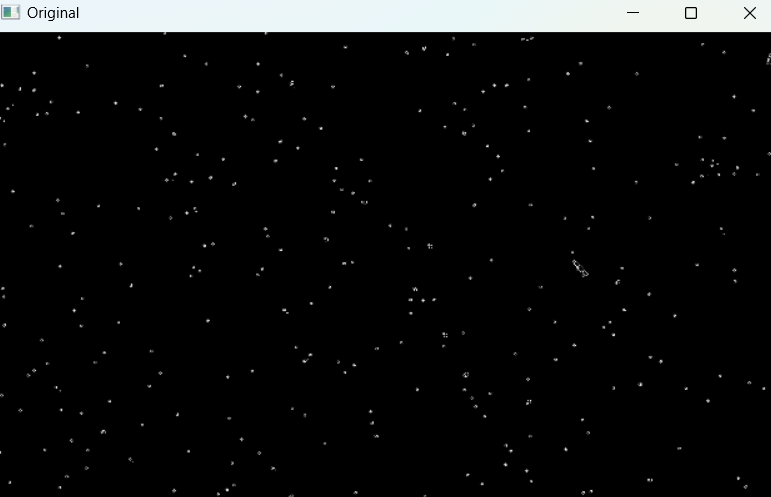

In [2]:
def main():
    # Load the image and convert to grayscale
    image_path='ST_db2.png'
    img ,keypoints = process_image(image_path)
    cv2.imshow('Original', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    for kp in keypoints:
        x,y = kp.pt
        r=kp.size
        b=kp.response
        print(f'x: ',{x}, f'y: ',{y}, f'r: ',{r}, f'b: ',{b})

x:  {16.564708709716797} y:  {259.44903564453125} r:  {1.738549828529358} b:  {0.022378353402018547}
x:  {22.376008987426758} y:  {229.9370880126953} r:  {1.7459964752197266} b:  {0.024086248129606247}
x:  {22.512048721313477} y:  {1118.5120849609375} r:  {1.7228845357894897} b:  {0.02494100295007229}
x:  {27.68964958190918} y:  {967.1912841796875} r:  {1.7283573150634766} b:  {0.00801833439618349}
x:  {28.512048721313477} y:  {141.51205444335938} r:  {1.7228845357894897} b:  {0.02494100295007229}
x:  {29.630290985107422} y:  {681.8135375976562} r:  {1.7254610061645508} b:  {0.006191962398588657}
x:  {33.51205062866211} y:  {704.5120239257812} r:  {1.7228845357894897} b:  {0.02494100295007229}
x:  {34.69218063354492} y:  {781.6028442382812} r:  {1.6924593448638916} b:  {0.008472414687275887}
x:  {36.51205062866211} y:  {300.5120544433594} r:  {1.7228845357894897} b:  {0.02494100295007229}
x:  {44.44902038574219} y:  {203.56471252441406} r:  {1.7385412454605103} b:  {0.02237836644053459}
x:  {49.5647087097168} y:  {1198.448974609375} r:  {1.738549828529358} b:  {0.022378353402018547}
x:  {56.69084930419922} y:  {424.305908203125} r:  {1.7300567626953125} b:  {0.0080299973487854}
x:  {75.69218444824219} y:  {152.60281372070312} r:  {1.6924593448638916} b:  {0.008472414687275887

## **Star tracker code**

In [ ]:
import random
import cv2
import numpy as np

# margin range 0.0-0.499..
def remove_edge_stars(keypoints, width, height, margin=0.1):
    # Define the range of x and y coordinates to include
    range_x = (int(width * margin), int(width * (1 - margin)))
    range_y = (int(height * margin), int(height * (1 - margin)))

    # Filter out keypoints that are outside the defined range
    filtered = [kp for kp in keypoints if range_x[0] <= kp.pt[0] <= range_x[1] and range_y[0] <= kp.pt[1] <= range_y[1]]

    return filtered

def process_image(image_path):
    # Load the image and convert to grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply a 5x5 Gaussian blur to the image
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply Canny edge detection with threshold values of 100 and 200
    filtered_img = cv2.Canny(img_blur, 100, 200)

    # Detect keypoints using SIFT
    sift = cv2.SIFT_create(sigma=1.6, edgeThreshold=20, contrastThreshold=0.07, nOctaveLayers=15)
    keypoints = sift.detect(filtered_img, None)

    # Remove keypoints that are too close to each other
    min_distance = 20  # minimum distance between keypoints
    filtered_keypoints = []
    for i, kp1 in enumerate(keypoints):
        is_close = False
        for kp2 in filtered_keypoints:
            distance = ((kp1.pt[0] - kp2.pt[0]) ** 2 + (kp1.pt[1] - kp2.pt[1]) ** 2) ** 0.5
            if distance < min_distance:
                is_close = True
                break
        if not is_close:
            filtered_keypoints.append(kp1)

    # Draw keypoints on the filtered image
    img_with_keypoints = cv2.drawKeypoints(filtered_img, filtered_keypoints, None, color=(255, 255, 255))

    return img_with_keypoints, filtered_keypoints

def ransac(keypoints, range_value, max_iterations):
    best_inliers = []
    best_p1 = None
    best_p2 = None

    for i in range(max_iterations):
        # Select 2 points at random
        p1, p2 = random.sample(keypoints, 2)

        # Compute slope and intercept of the line connecting the two points
        x1, y1 = p1.pt
        x2, y2 = p2.pt
        if x2 - x1 == 0:
            continue
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1

        # Find the inliers that lie within the range and between the two points
        inliers = []
        for kp in keypoints:
            x, y = kp.pt
            if abs(y - (slope * x + intercept)) < range_value:
                if x1 <= x <= x2 or x2 <= x <= x1:
                    inliers.append(kp)

        # Update the best set of inliers found so far
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_p1 = p1
            best_p2 = p2

    return len(best_inliers), best_inliers, best_p1, best_p2

def ransac_match(keypoints, range_value, max_iterations, inlier_count, delta):
    best_inliers = []
    best_p1 = None
    best_p2 = None

    for i in range(max_iterations):
        # Select 2 points at random
        p1, p2 = random.sample(keypoints, 2)

        # Compute slope and intercept of the line connecting the two points
        x1, y1 = p1.pt
        x2, y2 = p2.pt
        if x2 - x1 == 0:
            continue
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1

        # Find the inliers that lie within the range and between the two points
        inliers = []
        for kp in keypoints:
            x, y = kp.pt
            if abs(y - (slope * x + intercept)) < range_value:
                if x1 <= x <= x2 or x2 <= x <= x1:
                    inliers.append(kp)

        # Update the best set of inliers found so far
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_p1 = p1
            best_p2 = p2


        if (len(best_inliers) >= inlier_count - delta) and (len(best_inliers) >= inlier_count + delta):
            break

    return len(best_inliers), best_inliers, best_p1, best_p2

def draw_image(image, group_a_pts, group_b_pts, p1, p2):
    # Make a copy of the input image so we don't modify the original
    img = image.copy()

    # Draw group A points in yellow
    for pt in group_a_pts:
        cv2.circle(img, (int(pt.pt[0]), int(pt.pt[1])), 6, (0, 255, 255), -1)
    box_size = 10

    # Draw group B points in blue
    for pt in group_b_pts:
        cv2.circle(img, (int(pt.pt[0]), int(pt.pt[1])), 3, (255, 0, 0), -1)
        cv2.rectangle(img, (int(pt.pt[0]-10), int(pt.pt[1]-box_size)), (int(pt.pt[0]+box_size), int(pt.pt[1]+box_size)), (0, 255, 0), 2)
    # Draw a green square around points p1 and p2
    cv2.rectangle(img, (int(p1.pt[0]-box_size), int(p1.pt[1]-box_size)), (int(p1.pt[0]+box_size), int(p1.pt[1]+box_size)), (0, 255, 0), 2)
    cv2.rectangle(img, (int(p2.pt[0]-box_size), int(p2.pt[1]-box_size)), (int(p2.pt[0]+box_size), int(p2.pt[1]+box_size)), (0, 255, 0), 2)

    # Draw a red line between points p1 and p2
    cv2.line(img, (int(p1.pt[0]), int(p1.pt[1])), (int(p2.pt[0]), int(p2.pt[1])), (0, 0, 255), 2)
    image_with_lines_resized = cv2.resize(img, (0, 0), fx=0.30, fy=0.30)

    return image_with_lines_resized

def draw_image_match(image, group_a_pts, group_b_pts):
    # Make a copy of the input image so we don't modify the original
    img = image.copy()

    box_size = 15

    # Draw group B points in blue
    for pt in group_b_pts:
        cv2.rectangle(img, (int(pt.pt[0]-10), int(pt.pt[1]-box_size)), (int(pt.pt[0]+box_size), int(pt.pt[1]+box_size)), (0, 255, 0), 2)

    image_with_lines_resized = cv2.resize(img, (0, 0), fx=0.30, fy=0.30)

    return image_with_lines_resized

def transform_keypoints(input_pts, src_pt1, src_pt2, dst_pt1, dst_pt2):

    # Compute the transformation matrix using the two pairs of corresponding points
    src_pts = np.array([[src_pt1.pt[0], src_pt1.pt[1]], [src_pt2.pt[0], src_pt2.pt[1]]])
    dst_pts = np.array([[dst_pt1.pt[0], dst_pt1.pt[1]], [dst_pt2.pt[0], dst_pt2.pt[1]]])
    T = np.linalg.solve(src_pts, dst_pts)

    # Transform the input keypoints using the computed matrix
    transformed_pts = []
    for kp in input_pts:
        x, y = T @ np.array([kp.pt[0], kp.pt[1]])
        transformed_kp = cv2.KeyPoint(x, y, kp.size, kp.angle, kp.response, kp.octave, kp.class_id)
        transformed_pts.append(transformed_kp)

    return transformed_pts

def find_shared_keypoints(keypoints1, keypoints2, delta_range):
    shared_keypoints = []
    for kp1 in keypoints1:
        for kp2 in keypoints2:
            delta = np.sqrt((kp1.pt[0]-kp2.pt[0])**2 + (kp1.pt[1]-kp2.pt[1])**2)
            if delta <= delta_range:
                shared_keypoints.append(kp1)
                break
    return shared_keypoints

def main():
    # Load the image and convert to grayscale
    image_path='ST_db2.png'
    img ,keypoints = process_image(image_path)
    
    # Filter out keypoints on the edges of the image
    keypoints = remove_edge_stars(keypoints, img.shape[1], img.shape[0])
    
    # Fit a line to the remaining keypoints using RANSAC
    # inliers_count, slope, intercept, inliers, p1, p2= ransac(keypoints, 100, 10000)
    inliers_count,inliers, p1, p2= ransac(keypoints, 100, 1000000)
    image_with_line_resized= draw_image(img,keypoints,inliers,p1,p2)
    
    
    # Load the image and convert to grayscale
    image_path1='ST_db1.png'
    img1 ,keypoints1 = process_image(image_path1)
    # Filter out keypoints on the edges of the image
    keypoints1 = remove_edge_stars(keypoints1, img1.shape[1], img1.shape[0])
    
    # Fit a line to the remaining keypoints using RANSAC
    inliers_count1, inliers1, p11, p21 = ransac_match(keypoints1, 100, 1000000,inliers_count,0)
    image_with_line_resized1= draw_image(img1,keypoints1,inliers1,p11,p21)
    
    
    transformed_pts = transform_keypoints(keypoints, p1, p2, p11, p21)
    
    match_keypoints = find_shared_keypoints(transformed_pts,keypoints1,100)
    
    image_with_line_resized_match = draw_image_match(img1,keypoints1,match_keypoints)
    
    
    print(match_keypoints)
    # Show the image
    cv2.imshow('Original', image_with_line_resized)
    cv2.imshow('Opened', image_with_line_resized1)
    cv2.imshow('match', image_with_line_resized_match)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()


## **Star tracker code**

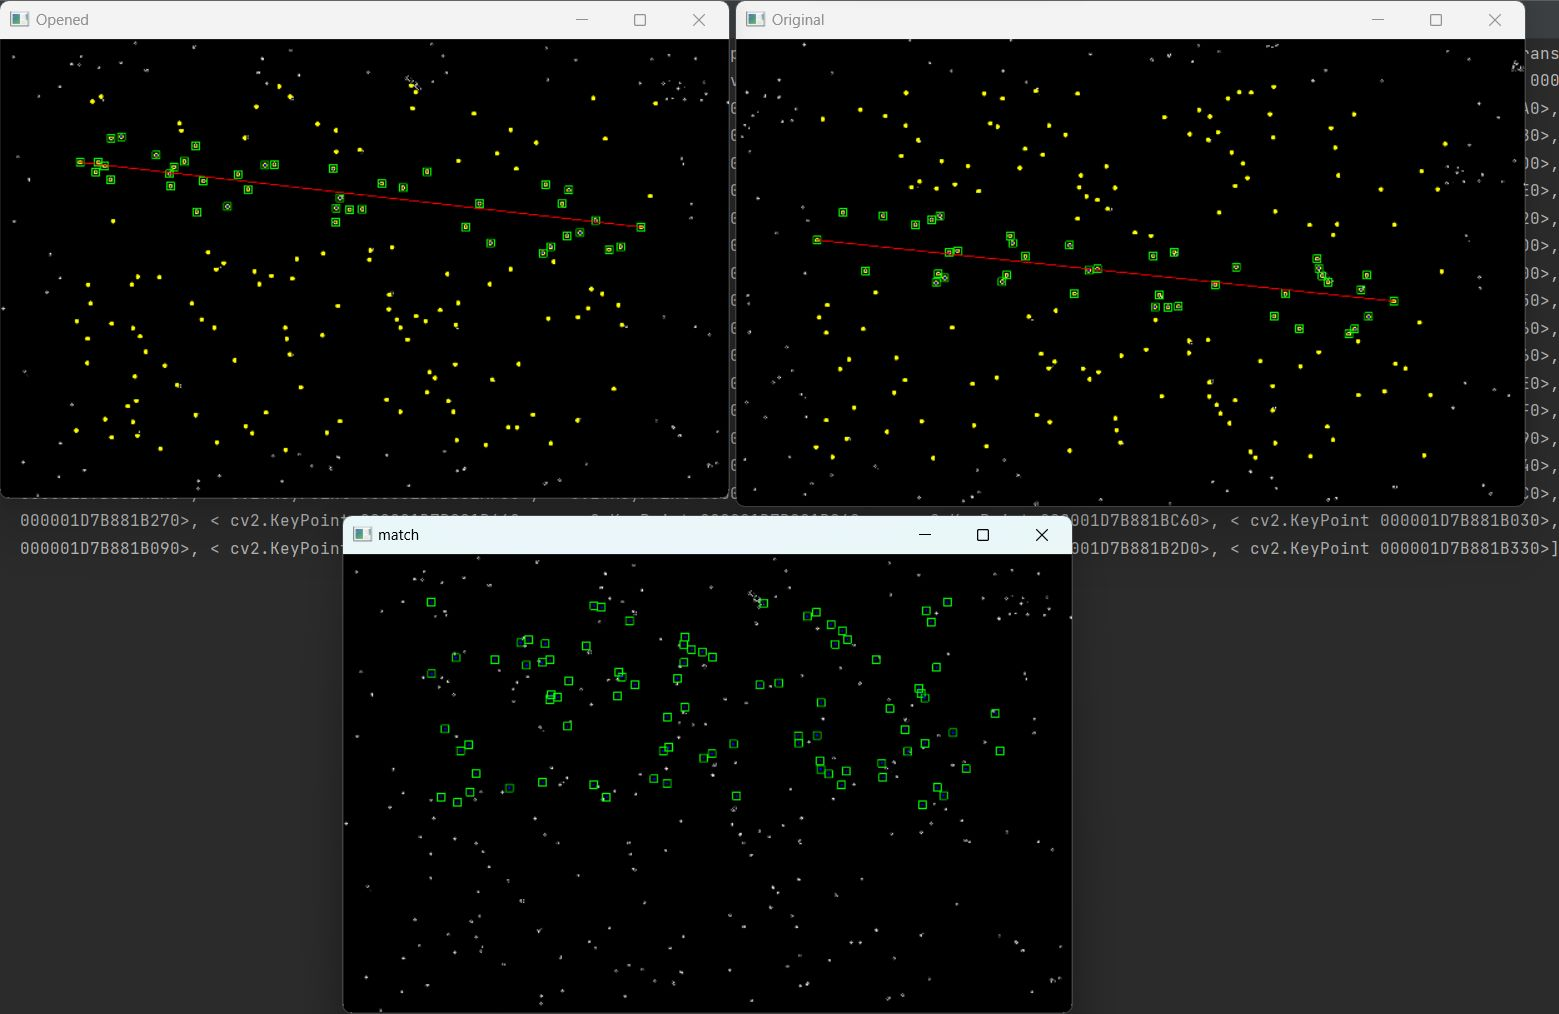

x:  {1666.4761962890625} y:  {1832.227294921875} r:  {3.097975254058838} b:  {0.008784842677414417}
x:  {1992.6312255859375} y:  {2414.5302734375} r:  {3.1606738567352295} b:  {0.008672099560499191}
x:  {2134.3193359375} y:  {1123.373779296875} r:  {1.5341321229934692} b:  {0.018342038616538048}
x:  {2549.3203125} y:  {1033.5736083984375} r:  {3.2235848903656006} b:  {0.00822540931403637}
x:  {2403.4375} y:  {362.87274169921875} r:  {3.2224247455596924} b:  {0.008219568058848381}
x:  {2487.42138671875} y:  {520.6972045898438} r:  {1.5601545572280884} b:  {0.02406891994178295}
x:  {2465.7470703125} y:  {315.12652587890625} r:  {3.1235036849975586} b:  {0.009160616435110569}


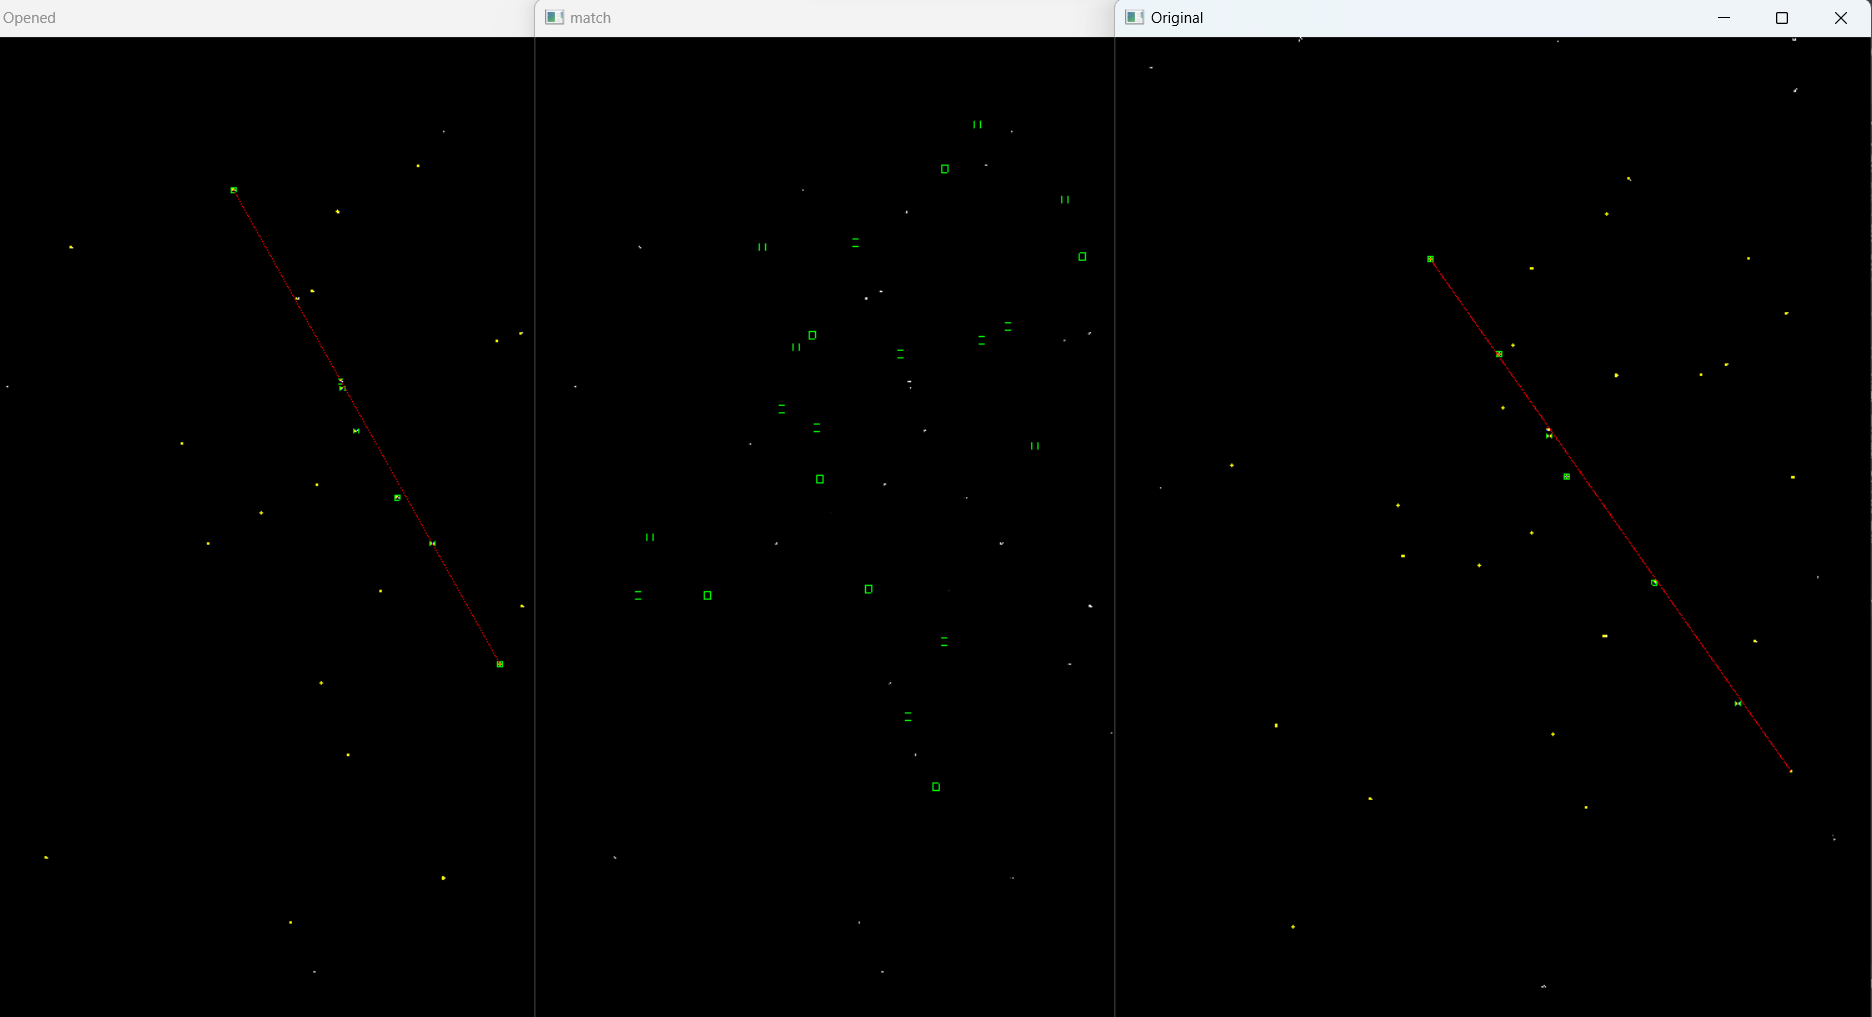

x:  {1280.3564453125} y:  {822.265869140625} r:  {3.1471667289733887} b:  {0.010081727989017963}
x:  {1125.4793701171875} y:  {1562.63916015625} r:  {3.2538726329803467} b:  {0.008466207422316074}
x:  {1124.9532470703125} y:  {1589.9739990234375} r:  {3.261110544204712} b:  {0.007802738342434168}
x:  {744.0675659179688} y:  {2969.95654296875} r:  {3.23193097114563} b:  {0.008321444503962994}
x:  {1138.9368896484375} y:  {1767.0572509765625} r:  {3.2473292350769043} b:  {0.008726101368665695}
x:  {774.7255859375} y:  {3289.17529296875} r:  {3.247652292251587} b:  {0.008728135377168655}
x:  {1069.6962890625} y:  {2484.104736328125} r:  {3.2206637859344482} b:  {0.007911903783679008}
x:  {1636.4635009765625} y:  {526.993408203125} r:  {3.25474214553833} b:  {0.006287946365773678}
x:  {1459.8883056640625} y:  {1268.899169921875} r:  {3.089726209640503} b:  {0.008747680112719536}
x:  {1766.539306640625} y:  {350.4098205566406} r:  {6.048573970794678} b:  {0.00514253880828619}
x:  {1331.361083984375} y:  {2206.80078125} r:  {3.2789297103881836} b:  {0.008952494710683823}
x:  {1785.632080078125} y:  {1212.8934326171875} r:  {3.259610414505005} b:  {0.008840610273182392}
x:  {1889.84228515625} y:  {1156.0863037109375} r:  {3.102757692337036} b:  {0.007279409095644951}
x:  {1489.4381103515625} y:  {2716.3818359375} r:  {3.1705710887908936} b:  {0.010687640868127346}
x:  {2117.081787109375} y:  {649.4939575195312} r:  {3.234191417694092} b:  {0.008336343802511692}
x:  {1634.721435546875} y:  {2416.866943359375} r:  {3.214362382888794} b:  {0.008270449005067348}
x:  {2188.14208984375} y:  {878.0044555664062} r:  {3.115875005722046} b:  {0.00949002429842949}
x:  {1601.451171875} y:  {2998.4794921875} r:  {3.0609285831451416} b:  {0.010357117280364037}
x:  {1997.5433349609375} y:  {1635.074951171875} r:  {3.0619122982025146} b:  {0.007188696414232254}

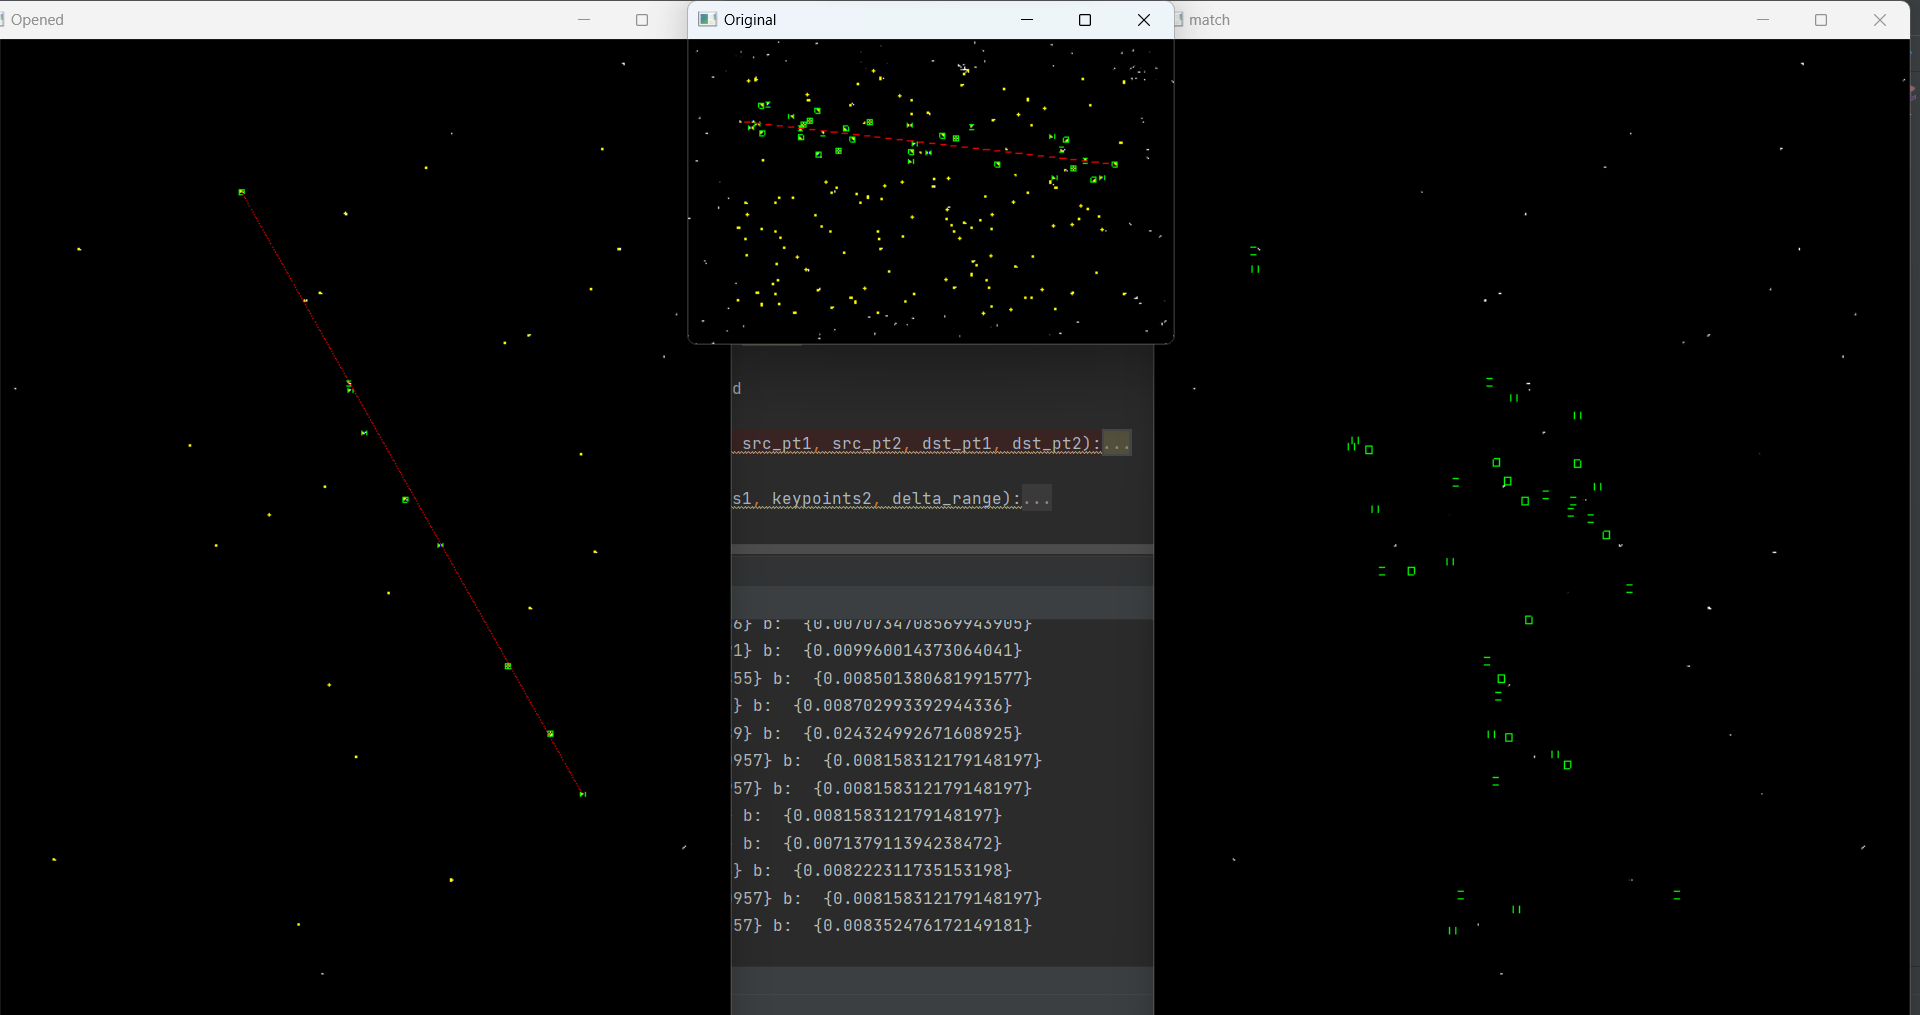

x:  {1691.5728759765625} y:  {1504.509521484375} r:  {3.226498603820801} b:  {0.008358900435268879}
x:  {1339.918212890625} y:  {1372.4522705078125} r:  {3.2328715324401855} b:  {0.008501380681991577}
x:  {1437.955810546875} y:  {1435.549072265625} r:  {1.5386264324188232} b:  {0.018437109887599945}
x:  {395.22357177734375} y:  {847.3621215820312} r:  {3.2128758430480957} b:  {0.008158312179148197}
x:  {403.7336120605469} y:  {920.3563842773438} r:  {3.239598035812378} b:  {0.008335048332810402}
x:  {1691.3094482421875} y:  {1698.215576171875} r:  {3.2328715324401855} b:  {0.008501380681991577}
x:  {1773.5318603515625} y:  {1789.45263671875} r:  {3.2128758430480957} b:  {0.008158312179148197}
x:  {1674.03271484375} y:  {1846.8175048828125} r:  {1.574351191520691} b:  {0.024324703961610794}
x:  {1368.3885498046875} y:  {1693.802734375} r:  {3.2231955528259277} b:  {0.00832835491746664}
x:  {1745.0640869140625} y:  {1916.2315673828125} r:  {3.2328715324401855} b:  {0.008501380681991577}


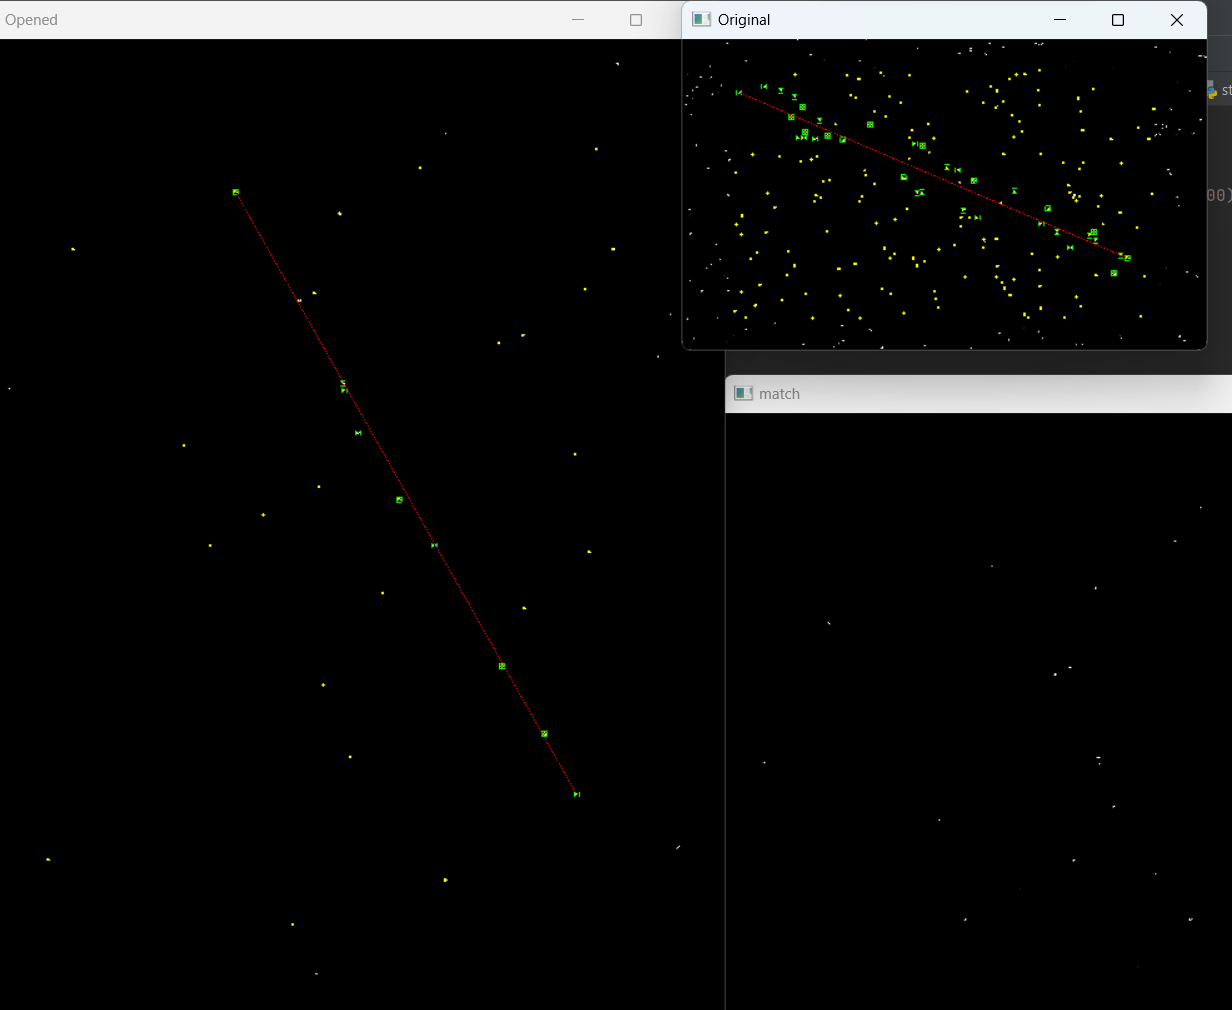